# В предыдущей серии


<img src="images/RNNCompar.png"/>


Мы посмотрели на задачу классификации текстов. Но есть ряд более сильных подходов, которые лучше показывать через задачу генерации


# Генерация текстов, encoder-decoder

<img src="images/EncDec.png"/>


Данная архитектура называется seq2seq, простыми словами выглядит она следующим образом:
<img src="images/seq2seq.png"/>


эту модель можно строить на уровне слов и на уровне токенов. Попробуем обучить на уровне токенов

In [1]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense
import numpy as np


Using TensorFlow backend.


In [2]:
batch_size = 64
epochs = 30
latent_dim = 256
num_samples = 10000
data_path = 'data/fra-eng/fra.txt'

In [3]:
# Собираем из текстов токены и делаем pne-hot вектора на каждый токен

input_texts = []
target_texts = []
input_characters = set()
target_characters = set()
with open(data_path, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')
for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text, _ = line.split('\t')
    target_text = '\t' + target_text + '\n'
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

In [4]:
input_token_index = dict(
    [(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict(
    [(char, i) for i, char in enumerate(target_characters)])

In [5]:
encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

In [6]:
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
    encoder_input_data[i, t + 1:, input_token_index[' ']] = 1.
    for t, char in enumerate(target_text):
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.
    decoder_input_data[i, t + 1:, target_token_index[' ']] = 1.
    decoder_target_data[i, t:, target_token_index[' ']] = 1.

In [7]:
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
encoder_states = [state_h, state_c]

decoder_inputs = Input(shape=(None, num_decoder_tokens))
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2)

encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())


def decode_sequence(input_seq):
    states_value = encoder_model.predict(input_seq)

    target_seq = np.zeros((1, 1, num_decoder_tokens))
    target_seq[0, 0, target_token_index['\t']] = 1.

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        states_value = [h, c]

    return decoded_sentence


for seq_index in range(100):
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Decoded sentence:', decoded_sentence)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 8000 samples, validate on 2000 samples
Epoch 1/30
8000/8000 [==============================] - 30s 4ms/step - loss: 1.3176 - accuracy: 0.7205 - val_loss: 1.0990 - val_accuracy: 0.7055
Epoch 2/30
8000/8000 [==============================] - 28s 4ms/step - loss: 0.8840 - accuracy: 0.7547 - val_loss: 0.9064 - val_accuracy: 0.7549
Epoch 3/30
8000/8000 [==============================] - 28s 4ms/step - loss: 0.7405 - accuracy: 0.7971 - val_loss: 0.7782 - val_accuracy: 0.7813
Epoch 4/30
8000/8000 [==============================] - 29s 4ms/step - loss: 0.6432 - accuracy: 0.8179 - val_loss: 0.7026 - val_accuracy: 0.7986
Epoch 5/30
8000/8000 [==============================] - 29s 4ms/step - loss: 0.5881 - accuracy: 0.8310 - val_loss: 0.6621 - val_accuracy: 0.8072
Epoch 6/30
8000/8000 [=============================

-
Input sentence: I'm OK.
Decoded sentence: Je suis des armien.

-
Input sentence: I'm OK.
Decoded sentence: Je suis des armien.

-
Input sentence: Listen.
Decoded sentence: La soyez !

-
Input sentence: No way!
Decoded sentence: C'est pas un pour !

-
Input sentence: No way!
Decoded sentence: C'est pas un pour !

-
Input sentence: No way!
Decoded sentence: C'est pas un pour !

-
Input sentence: No way!
Decoded sentence: C'est pas un pour !

-
Input sentence: No way!
Decoded sentence: C'est pas un pour !

-
Input sentence: No way!
Decoded sentence: C'est pas un pour !

-
Input sentence: No way!
Decoded sentence: C'est pas un pour !

-
Input sentence: No way!
Decoded sentence: C'est pas un pour !

-
Input sentence: No way!
Decoded sentence: C'est pas un pour !

-
Input sentence: Really?
Decoded sentence: At rappes ?

-
Input sentence: Really?
Decoded sentence: At rappes ?

-
Input sentence: Really?
Decoded sentence: At rappes ?

-
Input sentence: Thanks.
Decoded sentence: Prends pas !



Но есть проблемы:
- на длинных последовательностях результат будет не очень - быстро забывается контекст
- хочется научить сеть смотреть в определенное место в прошлом при генерации

attention

<img src="images/Attention.png"/>

<img src="images/Attention2.png"/>


- h(t): скрытое состояние декодера
- c(t): вектор контекста, который подается на вход
- y(t): текущий таргет
- $\bar{h}(t)$: скрытое состояние attention
- a(t): скор нормализации


$$\bar{h}(t)\ =\ tanh(W_c\ [c_t,\ h_t]) $$

$$P(y_t|y_{<t},\ x)\ =\ softmax(W_s\ \bar{h}_t) $$


Зачем нужен скор нормализации? - пытаемся сравнить похожесть текущего скрытого состояния и скрытого состояния из прошлого и понять, на что обращать внимание


$$a_t(s)\ =\ \frac{exp(score(h_t,\ \bar{h}_s))}{\sum_{i}\ exp(score(h_t,\ \bar{h}_i)) }$$ 


<img src="images/scores.png"/>

## Поднимемся на уровень слов, чтобы можно было что-то более адекватное посчитать за адекватное время

In [56]:
import re
import tensorflow as tf
data_path = 'data/fra-eng/fra.txt'
num_samples = 10000

tf.enable_eager_execution()

input_texts = []
target_texts = []

def preprocess_sentence(w):
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)
    w = w.strip()
    w = '<start> ' + w + ' <end>'
    return w

with open(data_path, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')

for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text, _ = line.split('\t')
    target_text = '\t' + target_text + '\n'
    input_texts.append(preprocess_sentence(input_text))
    target_texts.append(preprocess_sentence(target_text))

In [57]:
def tokenize(lang):
    lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
      filters='')
    lang_tokenizer.fit_on_texts(lang)
    tensor = lang_tokenizer.texts_to_sequences(lang)
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding='post')
    return tensor, lang_tokenizer

In [58]:
input_tensor, inp_lang_tokenizer = tokenize(input_texts)
target_tensor, targ_lang_tokenizer = tokenize(target_texts)

In [59]:
from sklearn.model_selection import train_test_split

input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

In [60]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 1024

vocab_inp_size = len(inp_lang_tokenizer.word_index)+1
vocab_tar_size = len(targ_lang_tokenizer.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [11]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.lstm = tf.keras.layers.GRU(self.enc_units,
                                       return_sequences=True,
                                       return_state=True)

    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.lstm(x, initial_state = hidden)
        return output, state

    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

    
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, query, values):
        query_with_time_axis = tf.expand_dims(query, 1)
        score = self.V(tf.nn.tanh(
            self.W1(query_with_time_axis) + self.W2(values)))

        attention_weights = tf.nn.softmax(score, axis=1)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights
    
    
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.lstm = tf.keras.layers.GRU(self.dec_units,
                                       return_sequences=True,
                                       return_state=True)
        self.fc = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, hidden, enc_output):
        context_vector, attention_weights = self.attention(hidden, enc_output)
        x = self.embedding(x)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        output, state = self.lstm(x)
        output = tf.reshape(output, (-1, output.shape[2]))
        x = self.fc(output)
        return x, state, attention_weights

In [12]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [15]:
@tf.function
def train_step(inp, targ, enc_hidden):
    loss = 0

    with tf.GradientTape() as tape:
        enc_output, enc_hidden = encoder(inp, enc_hidden)
        dec_hidden = enc_hidden
        dec_input = tf.expand_dims([targ_lang_tokenizer.word_index['<start>']] * BATCH_SIZE, 1)

        for t in range(1, targ.shape[1]):
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
            loss += loss_function(targ[:, t], predictions)
            dec_input = tf.expand_dims(targ[:, t], 1)
    
    batch_loss = (loss / int(targ.shape[1]))
    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    return batch_loss

In [16]:
EPOCHS = 10
for epoch in range(EPOCHS):
    enc_hidden = encoder.initialize_hidden_state()
    total_loss = 0

    for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
        batch_loss = train_step(inp, targ, enc_hidden)
        total_loss += batch_loss
    
    print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1 Loss 1.6334
Epoch 2 Loss 1.1838
Epoch 3 Loss 0.9790
Epoch 4 Loss 0.8312
Epoch 5 Loss 0.7131
Epoch 6 Loss 0.6077
Epoch 7 Loss 0.5167
Epoch 8 Loss 0.4360
Epoch 9 Loss 0.3691
Epoch 10 Loss 0.3080


Некоторые украденные функции для оценки

In [27]:
max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]

def evaluate(sentence):
    attention_plot = np.zeros((max_length_targ, max_length_inp))
    sentence = preprocess_sentence(sentence)
    inputs = [inp_lang_tokenizer.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
    inputs = tf.convert_to_tensor(inputs)
    result = ''
    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)
    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang_tokenizer.word_index['<start>']], 0)

    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += targ_lang_tokenizer.index_word[predicted_id] + ' '

        if targ_lang_tokenizer.index_word[predicted_id] == '<end>':
            return result, sentence, attention_plot
        dec_input = tf.expand_dims([predicted_id], 0)
    return result, sentence, attention_plot

def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')
    fontdict = {'fontsize': 14}
    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    plt.show()
    
def translate(sentence):
    result, sentence, attention_plot = evaluate(sentence)
    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))
    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

Populating the interactive namespace from numpy and matplotlib
Input: <start> good morning <end>
Predicted translation: sois gentil ! <end> 


/home/kinetik/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


NameError: name 'ticker' is not defined

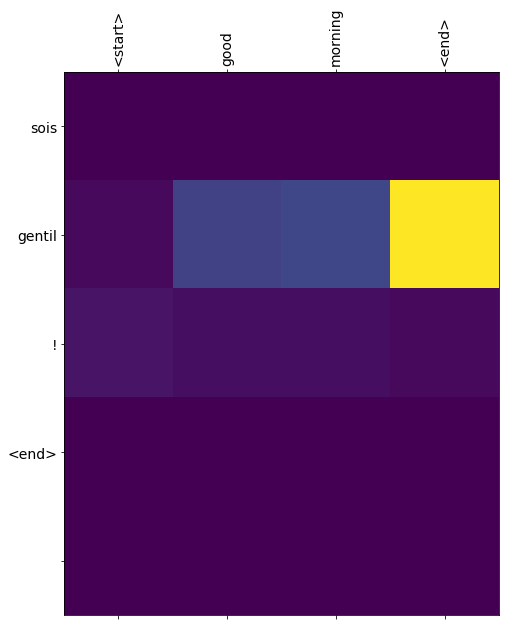

In [29]:
%pylab inline

translate(u'good morning')

# Transformer

<img src="images/transformer.png"/>


Идея в том, что каждое слово параллельно проходит через слои, изображенные на картинке.
Некоторые из них — это стандартные fully-connected layers, некоторые — shortcut connections как в ResNet (там, где на картинке Add).


Multi-head attention - это специальный новый слой, который дает возможность каждому входному вектору взаимодействовать с другими словами через attention mechanism, вместо передачи hidden state как в RNN или соседних слов как в CNN.


<img src="images/mha.png"/>


<img src="images/AttTr.png"/>


Работа энкодера:


Делаются эмбеддинги для всех слов предложения (вектора одинаковой размерности). Для примера пусть это будет предложение I am stupid. В эмбеддинг добавляется еще позиция слова в предложении.


Берется вектор первого слова и вектор второго слова (I, am), подаются на однослойную сеть с одним выходом, которая выдает степень их похожести (скалярная величина). Эта скалярная величина умножается на вектор второго слова, получая его некоторую "ослабленную" на величину похожести копию.


Вместо второго слова подается третье слово и делается тоже самое что в п.2. с той же самой сетью с теми же весами (для векторов I, stupid).


Делая тоже самое для всех оставшихся слов предложения получаются их "ослабленные" (взвешенные) копии, которые выражают степень их похожести на первое слово. Далее эти все взвешенные вектора складываются друг с другом, получая один результирующий вектор размерности одного эмбединга:
output=am * weight(I, am) + stupid * weight(I, stupid)


Это механизм "обычного" attention.
Так как оценка похожести слов всего одним способом (по одному критерию) считается недостаточной, тоже самое (п.2-4) повторяется несколько раз с другими весами. Типа одна один attention может определять похожесть слов по смысловой нагрузке, другой по грамматической, остальные еще как-то и т.п.


На выходе п.5. получается несколько векторов, каждый из которых является взвешенной суммой всех остальных слов предложения относительно их похожести на первое слово (I). Конкантенируем этот вректор в один.


Дальше ставится еще один слой линейного преобразования, уменьшающий размерность результата п.6. до размерности вектора одного эмбединга. Получается некое представление первого слова предложения, составленное из взвешенных векторов всех остальных слов предложения.


Такой же процесс производится для всех других слов в предложении.


Так как размерность выхода та же, то можно проделать все тоже самое еще раз (п.2-8), но вместо оригинальных эмбеддингов слов взять то, что получается после прохода через этот Multi-head attention, а нейросети аттеншенов внутри взять с другими весами (веса между слоями не общие). И таких слоев можно сделать много (у гугла 6). Однако между первым и вторым слоем добавляется еще полносвязный слой и residual соединения, чтобы добавить сети выразительности.

In [61]:
def scaled_dot_product_attention(q, k, v, mask):
    """Calculate the attention weights.
  q, k, v must have matching leading dimensions.
  k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
  The mask has different shapes depending on its type(padding or look ahead) 
  but it must be broadcastable for addition.
  
  Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable 
          to (..., seq_len_q, seq_len_k). Defaults to None.
    
  Returns:
    output, attention_weights
    """

    matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
  
  # scale matmul_qk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  # add the mask to the scaled tensor.
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)  

  # softmax is normalized on the last axis (seq_len_k) so that the scores
  # add up to 1.
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

    output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)
    return output, attention_weights

In [62]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)
        
    def split_heads(self, x, batch_size):
        """Split the last dimension into (num_heads, depth).
        Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    
    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)

        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

        concat_attention = tf.reshape(scaled_attention, 
                                      (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

        return output, attention_weights
    
def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

In [63]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
    
    def call(self, x, training, mask):

        attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)

        return out2
    
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)

        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)

    
    def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):
        # enc_output.shape == (batch_size, input_seq_len, d_model)

        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)

        attn2, attn_weights_block2 = self.mha2(
            enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)

        ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

        return out3, attn_weights_block1, attn_weights_block2
    
    
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               maximum_position_encoding, rate=0.1):
        super(Encoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, 
                                                self.d_model)


        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) 
                           for _ in range(num_layers)]

        self.dropout = tf.keras.layers.Dropout(rate)
        
    def call(self, x, training, mask):

        seq_len = tf.shape(x)[1]

        # adding embedding and position encoding.
        x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)

        return x  # (batch_size, input_seq_len, d_model)

In [64]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
               maximum_position_encoding, rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) 
                           for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)
    
    def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):

        seq_len = tf.shape(x)[1]
        attention_weights = {}

        x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                                 look_ahead_mask, padding_mask)

            attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i+1)] = block2

        # x.shape == (batch_size, target_seq_len, d_model)
        return x, attention_weights

In [65]:
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, 
               target_vocab_size, pe_input, pe_target, rate=0.1):
        super(Transformer, self).__init__()

        self.encoder = Encoder(num_layers, d_model, num_heads, dff, 
                               input_vocab_size, pe_input, rate)

        self.decoder = Decoder(num_layers, d_model, num_heads, dff, 
                               target_vocab_size, pe_target, rate)

        self.final_layer = tf.keras.layers.Dense(target_vocab_size)
    
    def call(self, inp, tar, training, enc_padding_mask, 
           look_ahead_mask, dec_padding_mask):

        enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)

        # dec_output.shape == (batch_size, tar_seq_len, d_model)
        dec_output, attention_weights = self.decoder(
            tar, enc_output, training, look_ahead_mask, dec_padding_mask)

        final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)

        return final_output, attention_weights

In [66]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8

input_vocab_size = len(inp_lang_tokenizer.index_word) + 2
target_vocab_size = len(targ_lang_tokenizer.index_word) + 2
dropout_rate = 0.1

In [67]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [68]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
  
    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [69]:
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates

def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)
  
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
    pos_encoding = angle_rads[np.newaxis, ...]
    
    return tf.cast(pos_encoding, dtype=tf.float32)

In [70]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    name='train_accuracy')

transformer = Transformer(num_layers, d_model, num_heads, dff,
                          input_vocab_size, target_vocab_size, 
                          pe_input=input_vocab_size, 
                          pe_target=target_vocab_size,
                          rate=dropout_rate)

In [71]:
def create_masks(inp, tar):
    enc_padding_mask = create_padding_mask(inp)
  
    dec_padding_mask = create_padding_mask(inp)
  
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
  
    return enc_padding_mask, combined_mask, dec_padding_mask

In [72]:

train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int32),
    tf.TensorSpec(shape=(None, None), dtype=tf.int32),
]

@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]
  
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)
  
    with tf.GradientTape() as tape:
        predictions, _ = transformer(inp, tar_inp, 
                                 True, 
                                 enc_padding_mask, 
                                 combined_mask, 
                                 dec_padding_mask)
        loss = loss_function(tar_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
  
    train_loss(loss)
    train_accuracy(tar_real, predictions)

In [73]:
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
  
  # add extra dimensions to add the padding
  # to the attention logits.
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (seq_len, seq_len)

for epoch in range(100):
    train_loss.reset_states()
    train_accuracy.reset_states()
  
    for (batch, (inp, tar)) in enumerate(dataset.take(steps_per_epoch)):
        train_step(inp, tar)
        if batch % 50 == 0:
            print ('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
              epoch + 1, batch, train_loss.result(), train_accuracy.result()))
    
    print ('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1, 
                                                train_loss.result(), 
                                                train_accuracy.result()))

Epoch 1 Batch 0 Loss 8.2704 Accuracy 0.0000
Epoch 1 Batch 50 Loss 8.1042 Accuracy 0.0148
Epoch 1 Batch 100 Loss 7.8725 Accuracy 0.0404
Epoch 1 Loss 7.7805 Accuracy 0.0455
Epoch 2 Batch 0 Loss 7.2858 Accuracy 0.0667
Epoch 2 Batch 50 Loss 7.1240 Accuracy 0.0667
Epoch 2 Batch 100 Loss 6.9004 Accuracy 0.0667
Epoch 2 Loss 6.7806 Accuracy 0.0667
Epoch 3 Batch 0 Loss 6.0503 Accuracy 0.0667
Epoch 3 Batch 50 Loss 5.7819 Accuracy 0.1003
Epoch 3 Batch 100 Loss 5.5084 Accuracy 0.1095
Epoch 3 Loss 5.3948 Accuracy 0.1131
Epoch 4 Batch 0 Loss 4.7114 Accuracy 0.1333
Epoch 4 Batch 50 Loss 4.5756 Accuracy 0.1387
Epoch 4 Batch 100 Loss 4.4015 Accuracy 0.1455
Epoch 4 Loss 4.3359 Accuracy 0.1478
Epoch 5 Batch 0 Loss 3.8642 Accuracy 0.1708
Epoch 5 Batch 50 Loss 3.8154 Accuracy 0.1682
Epoch 5 Batch 100 Loss 3.7026 Accuracy 0.1732
Epoch 5 Loss 3.6671 Accuracy 0.1746
Epoch 6 Batch 0 Loss 3.3714 Accuracy 0.1917
Epoch 6 Batch 50 Loss 3.3321 Accuracy 0.1888
Epoch 6 Batch 100 Loss 3.2596 Accuracy 0.1922
Epoch 6 Lo

In [92]:
def evaluate(inp_sentence):
    start_token = [1]
    end_token = [2]
  
    sentence = preprocess_sentence(inp_sentence)
    inputs = [inp_lang_tokenizer.word_index[i] for i in sentence.split(' ')]
    
    encoder_input = tf.expand_dims(inputs, 0)
  
  # as the target is english, the first word to the transformer should be the
  # english start token.
    decoder_input = [1]
    output = tf.expand_dims(decoder_input, 0)
    
    for i in range(max_length_targ):
        enc_padding_mask, combined_mask, dec_padding_mask = create_masks(
            encoder_input, output)
  
    # predictions.shape == (batch_size, seq_len, vocab_size)
        predictions, attention_weights = transformer(encoder_input, 
                                                 output,
                                                 False,
                                                 enc_padding_mask,
                                                 combined_mask,
                                                 dec_padding_mask)
    
    # select the last word from the seq_len dimension
        predictions = predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)

        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
    
    # return the result if the predicted_id is equal to the end token
        if predicted_id == targ_lang_tokenizer.word_index["<end>"]:
            return tf.squeeze(output, axis=0), attention_weights
    
    # concatentate the predicted_id to the output which is given to the decoder
    # as its input.
        output = tf.concat([output, predicted_id], axis=-1)

    return tf.squeeze(output, axis=0), attention_weights


def plot_attention_weights(attention, sentence, result, layer):
    fig = plt.figure(figsize=(16, 8))
  
    sentence = inp_lang_tokenizer.encode(sentence)
  
    attention = tf.squeeze(attention[layer], axis=0)
  
    for head in range(attention.shape[0]):
        ax = fig.add_subplot(2, 4, head+1)

        # plot the attention weights
        ax.matshow(attention[head][:-1, :], cmap='viridis')

        fontdict = {'fontsize': 10}

        ax.set_xticks(range(len(sentence)+2))
        ax.set_yticks(range(len(result)))

        ax.set_ylim(len(result)-1.5, -0.5)

        ax.set_xticklabels(
            ['<start>']+[tokenizer_pt.decode([i]) for i in sentence]+['<end>'], 
            fontdict=fontdict, rotation=90)

        ax.set_yticklabels([tokenizer_en.decode([i]) for i in result 
                            if i < tokenizer_en.vocab_size], 
                           fontdict=fontdict)

        ax.set_xlabel('Head {}'.format(head+1))
  
    plt.tight_layout()
    plt.show()

def translate(sentence, plot=''):
    result, attention_weights = evaluate(sentence)
    predicted_sentence = ([targ_lang_tokenizer.index_word[i] for i in result.numpy()])  

    print('Input: {}'.format(sentence))
    print('Predicted translation: {}'.format(predicted_sentence))
  
    if plot:
        plot_attention_weights(attention_weights, sentence, result, plot)
        
translate("good morning.")

Input: good morning.
Predicted translation: ['<start>', 'quel', 'quel', 'porte', '!', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '!', '<end>', '<end>', '<end>', '<end>']
